In [1]:
import git
repo = git.Repo('.', search_parent_directories=True)
repo_loc = repo.working_tree_dir

import os
import sys
from pathlib import Path

sys.path.append(repo_loc)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.covid19_plot_func import plot_state_num, plot_death_cause, plot_death_cumsum, plot_death_icu_rate
from src.covid19_prob_parameter import P_matrix
from src.covid19_model import run_model

from src.covid19_region_attr import create_region
from src import conf_helper as cf

In [20]:
df_temp.to_csv('df_wuhan_20200412.csv', index=False)

In [16]:
config_file = 'nsw_20200425.yaml'
# config = cf.CovidConf(project_dir=repo_loc, config_file=config_file, config_dir='config/region_model')
region = create_region(config_file)

In [17]:
print("region_name: ", region.region_name)
print("country: ", region.country)
print("Daily cases: ", region.daily_case)
print("Daily accumulated cases: ", region.acc_case)
print("Population: ", region.pop)
print("Population ratio: ", region.pop_ratio)
print("Estimated number of ICU: ", region.t_icu_est)
print("Number of ICU required: ", region.t_icu_ade)
print("Number of deaths: ", region.n_death)

region_name:  NSW
country:  Australia
Daily cases:  [  3   1   0   0   0   0   0   0   0   0   1   1   3   6   7   3   3   8
   4   7  13   4  13  14  20  22  37  39  57  40  75  54  97 172 209 116
 190 186 212 174 127 114 150 116  91 104  87  57  49  48  39  49  35  -3
   9   7  16  11  29  10  21   6   6   2   5   6  12]
Daily accumulated cases:  [   3    4    4    4    4    4    4    4    4    4    5    6    9   15
   22   25   28   36   40   47   60   64   77   91  111  133  170  209
  266  306  381  435  532  704  913 1029 1219 1405 1617 1791 1918 2032
 2182 2298 2389 2493 2580 2637 2686 2734 2773 2822 2857 2854 2863 2870
 2886 2897 2926 2936 2957 2963 2969 2971 2976 2982 2994]
Population:  [ 943319  891434 1016834 1040084  995609  955272  804514  509864  323312]
Population ratio:  [0.12610809 0.11917181 0.13593598 0.13904416 0.1330985  0.12770603
 0.10755187 0.06816143 0.04322213]
Estimated number of ICU:  874
Number of ICU required:  230
Number of deaths:  33


In [3]:
###########################################
# Choose the region to test the model with
###########################################
# bavaria, lombardy, wuhan, nsw
region = lombardy

n_days = len(region.daily_case) + 50

##### Setting hopsital beds, ICU and ventilator numbers #####

t_hosp_bed = 2000 # Assuming there is enough number of beds

# Set the t_icu number
# Can set it to region.t_icu_est (estimated available ICU avaiable for the region), region.t_icu_ade (adequate ICU number for the region) or any numbers one wants
t_icu = region.t_icu_est

# Initial number of ICU beds. If t_icu_portion is a list, then will run with multiple tests with different t_icu_portion
# t_icu_portion = [1/10, 1/5, 1/2, 1]
# t_icu_portion = np.arange(0.0, 1.01, 0.01)
t_icu_portion = ""


if t_icu_portion !="":
    t_icu = (np.array(t_icu_portion)*t_icu).round()
else:
    t_icu = [t_icu]
t_vent = (np.array(t_icu)*0.6).round() # Initial number of ventilators

############
# Run model
############
list_df_infected = []
list_df_death_cause = []

print("Run model for region: ", region.region_name)
list_df_infected, list_df_death_cause = run_model(region.daily_case, region.pop_ratio, n_days, P_matrix, t_hosp_bed, t_icu, t_vent)

Run model for region:  Lombardy
t_icu:  1174
Running model for Day 0...
Running model for Day 10...
Running model for Day 20...
Running model for Day 30...
Running model for Day 40...
Running model for Day 50...
Running model for Day 60...
Running model for Day 70...
Running model for Day 80...
Running model for Day 90...
Running model for Day 100...
Finished running model for t_icu value of 1174



## Plotting

#### Number of patients in different state plot (plot_state_num)

AttributeError: 'XTick' object has no attribute 'label'

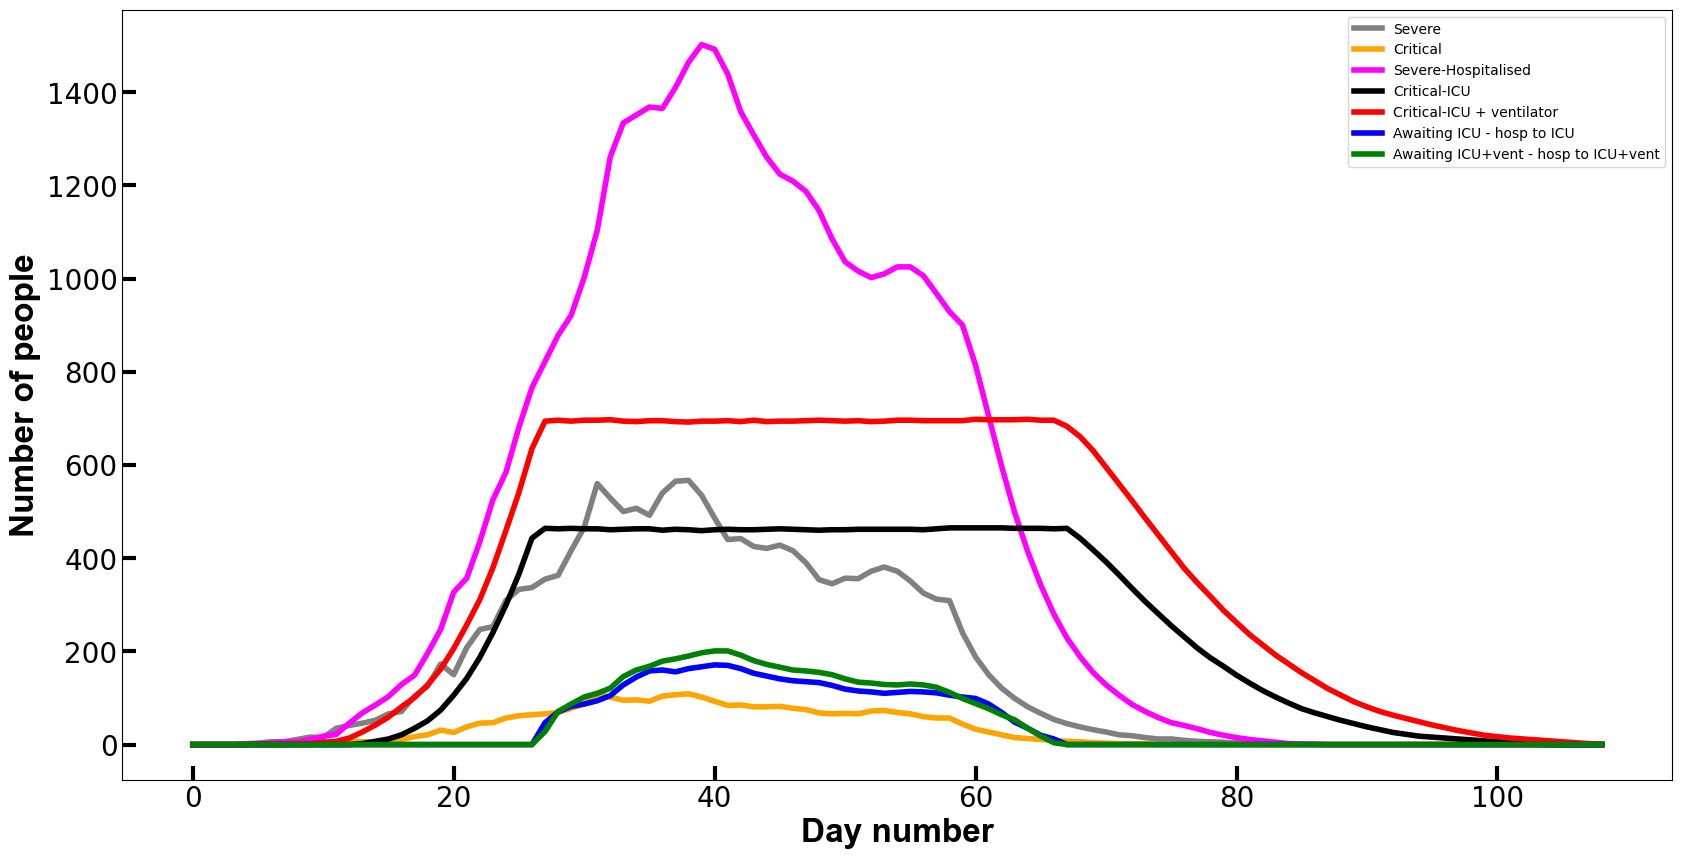

In [4]:
df_infected = list_df_infected[0]
plot_state_num(df_infected, region.daily_case.sum(), region.get_plot_title('plot_state_num', t_icu[0]))

### Number of deaths due to different causes over time

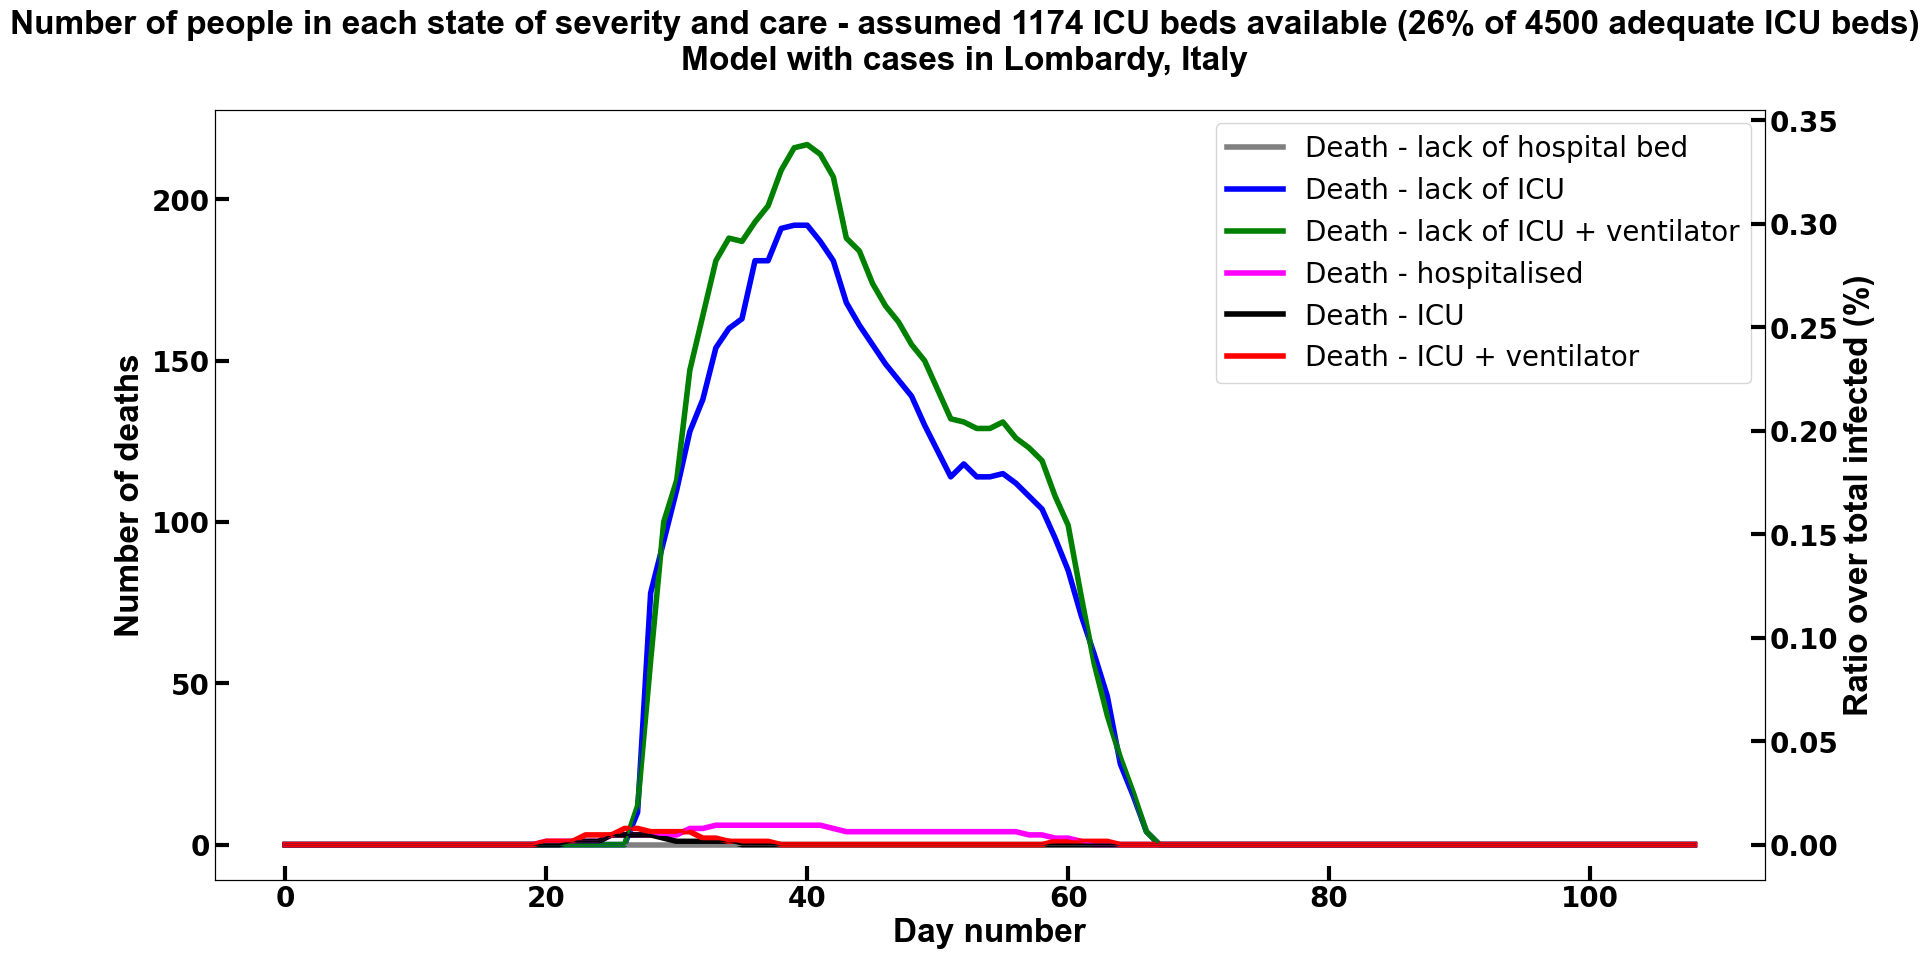

In [5]:
df_death_cause = list_df_death_cause[0]
plot_death_cause(df_death_cause, region.daily_case.sum(), region.get_plot_title('plot_death_acc', t_icu[0]))

### Accumulated number of deaths due to different cuases over time

(<Figure size 2000x1000 with 2 Axes>,
 <Axes: xlabel='Day number', ylabel='Number of deaths'>,
 <Axes: ylabel='Ratio over total infected (%)'>)

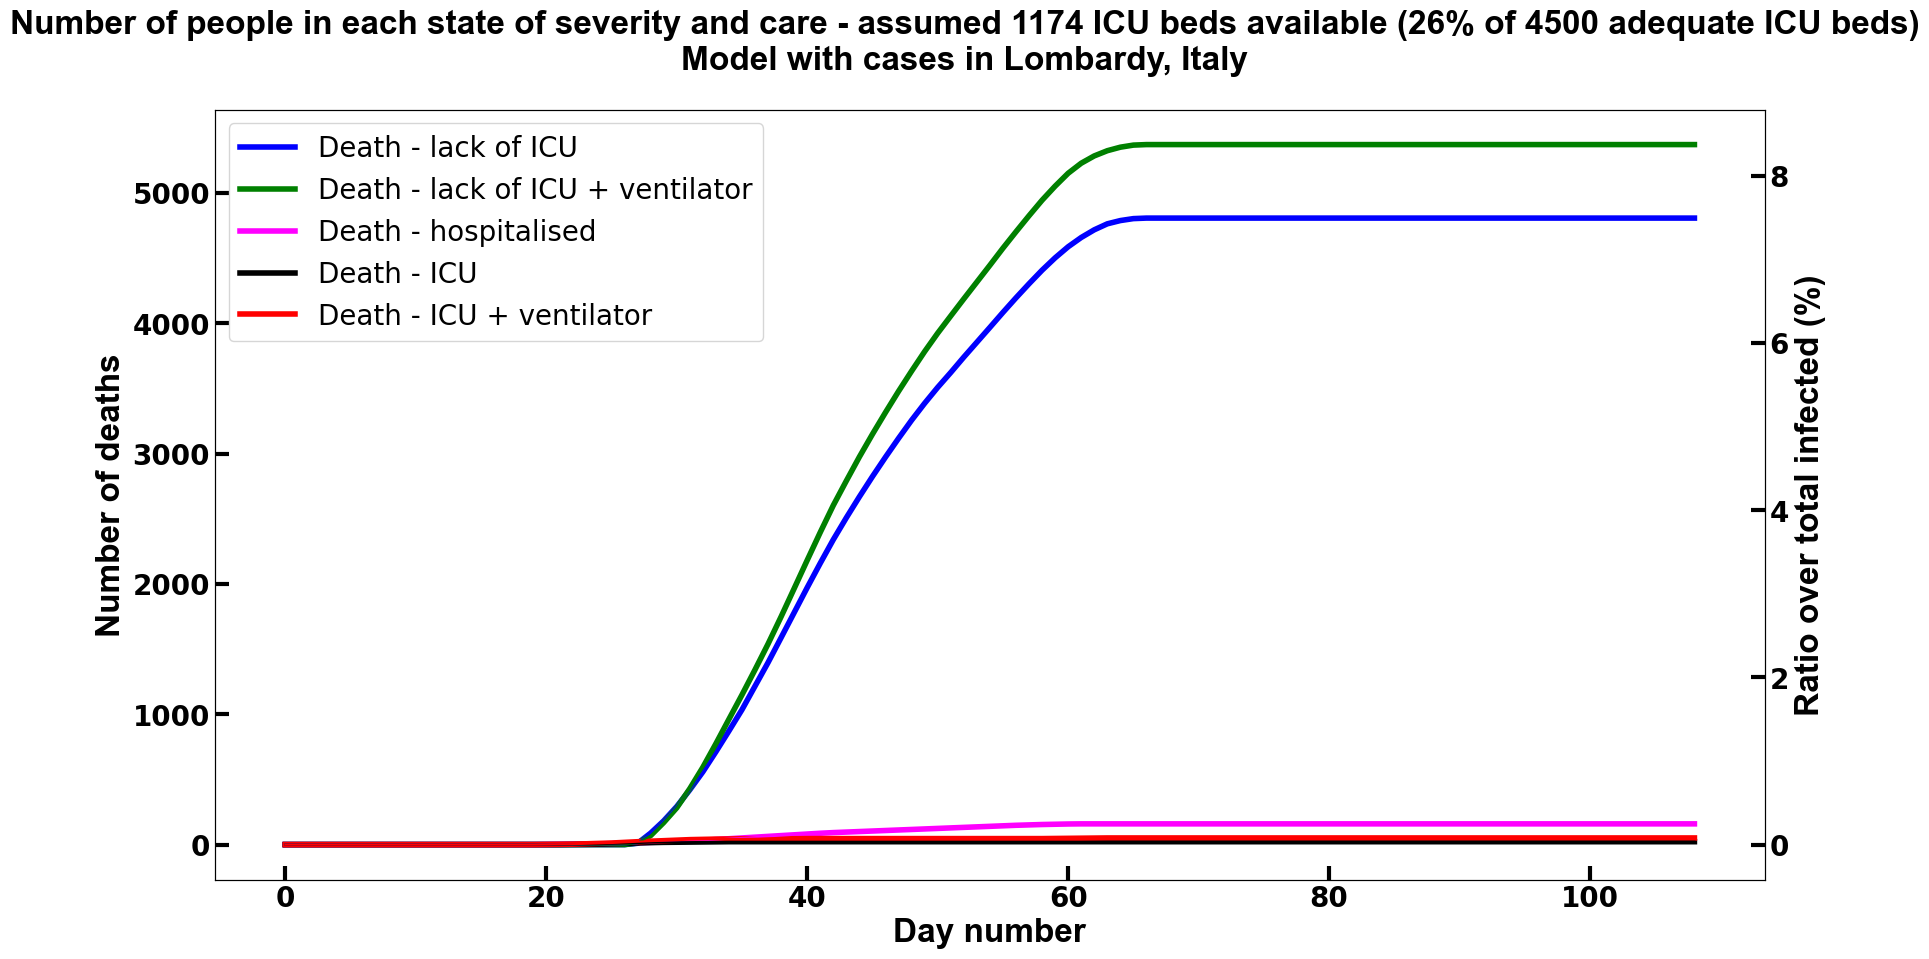

In [6]:
plot_death_cumsum(df_death_cause, region.daily_case.sum(), region.get_plot_title('plot_death_acc', t_icu[0]))